### Regression model for predicting Car Fuel Efficiency

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Get Car Fuel Efficiency data from Kaggle
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

car_efficiency_df = pd.read_csv(url)
car_efficiency_df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [2]:
# describe the data
car_efficiency_df.describe()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,num_doors,fuel_efficiency_mpg
count,9704.000000,9222.000000,8996.000000,9704.000000,8774.000000,9704.000000,9202.000000,9704.000000
mean,199.708368,3.962481,149.657292,3001.280993,15.021928,2011.484027,-0.006412,14.985243
std,49.455319,1.999323,29.879555,497.894860,2.510339,6.659808,1.048162,2.556468
min,10.000000,0.000000,37.000000,952.681761,6.000000,2000.000000,-4.000000,6.200971
25%,170.000000,3.000000,130.000000,2666.248985,13.300000,2006.000000,-1.000000,13.267459
50%,200.000000,4.000000,149.000000,2993.226296,15.000000,2012.000000,0.000000,15.006037
75%,230.000000,5.000000,170.000000,3334.957039,16.700000,2017.000000,1.000000,16.707965
max,380.000000,13.000000,271.000000,4739.077089,24.300000,2023.000000,4.000000,25.967222


In [3]:
# preparing the data
car_df = car_efficiency_df[['engine_displacement', 'horsepower', 'vehicle_weight', 'fuel_efficiency_mpg']]
car_df.head()

,engine_displacement,horsepower,vehicle_weight,fuel_efficiency_mpg
0,170,159.0,3413.433759,13.231729
1,130,97.0,3149.664934,13.688217
2,170,78.0,3079.038997,14.246341
3,220,NaN,2542.392402,16.912736
4,210,140.0,3460.870990,12.488369


#### Exploratory Data Analysis

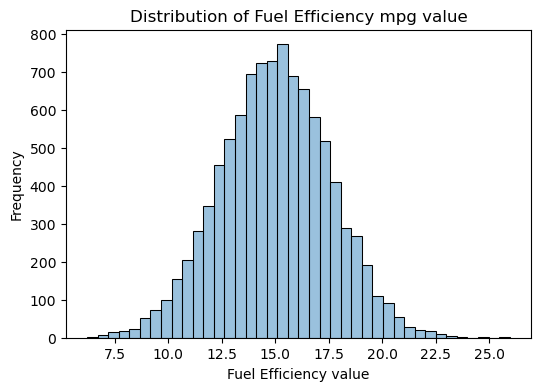

In [4]:
# Distribution of fuel_efficiency_mpg value
plt.figure(figsize=(6, 4))
sns.histplot(car_df.fuel_efficiency_mpg, bins=40, alpha=0.45)
plt.ylabel('Frequency')
plt.xlabel('Fuel Efficiency value')
plt.title('Distribution of Fuel Efficiency mpg value')

plt.show()

In [5]:
# function to calculate the percentage of missing values
def missing_values_table(df):
    """
    This function calculates the percentage of
    missing values in the dataset
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

##### Question 1

In [7]:
# check for missing values
missing_values_table(car_df)

Your selected dataframe has 4 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
horsepower,708,7.3


##### Question 2

In [8]:
# Median of `horsepower`
car_df.horsepower.median()

149.0

##### Question 3

#### Prepare and split the dataset

In [9]:
np.random.seed(42)

n = len(car_df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = car_df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [10]:
# Apply log transformation to `fuel_efficiency_mpg` value
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [11]:
# linear regression function
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [12]:
# Filling missing value with mean
def prepare_X(df):
    mean_horsepower = df.horsepower.mean()
    df['horsepower'] = df['horsepower'].fillna(value = mean_horsepower)
    X = df.values
    return X

# Get target
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

# Get prediction
y_pred = w_0 + X_train.dot(w)


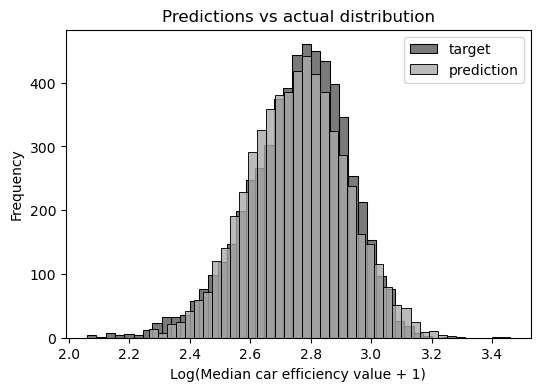

In [13]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Median car efficiency value + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [14]:
rmse(y_train, y_pred)

np.float64(0.0358111224824418)

In [15]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [16]:
round(rmse(y_val, y_pred), 2)

np.float64(0.04)

In [17]:
# Filling missing value with zero
def prepare_X_0(df):
    df['horsepower'] = df['horsepower'].fillna(value = 0)
    X = df.values
    return X

# Get target
X_train_0 = prepare_X_0(df_train)
w_0, w = train_linear_regression(X_train_0, y_train)

# Get prediction
y_pred_0 = w_0 + X_train_0.dot(w)


In [18]:
rmse(y_train, y_pred_0)

np.float64(0.0358111224824418)

In [19]:
X_val_0 = prepare_X_0(df_val)
y_pred_0 = w_0 + X_val_0.dot(w)

In [20]:
round(rmse(y_val, y_pred_0), 2)

np.float64(0.04)

##### Question 4

In [21]:
# Using Regularization
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [22]:
# train without regularization
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.0358111224824418
validation: 0.03732816779400693


In [23]:
# Apply regularization
X_train = prepare_X_0(df_train)
X_val = prepare_X_0(df_val)

print('regularization param', 'rmse')
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = round(rmse(y_val, y_pred), 4)
    print('{:>20} {:>2}'.format(r, rmse_val))

regularization param rmse
                   0 0.0373
               1e-06 0.0373
              0.0001 0.0373
               0.001 0.0373
                0.01 0.0373
                 0.1 0.0373
                   1 0.0378
                   5 0.0468
                  10 0.0646


##### Question 5

In [24]:
all_rmse = []
seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for s in seed:
    np.random.seed(s)
    n = len(car_df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = car_df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    # Apply log transformation to `fuel_efficiency_mpg` value
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
    y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    # Apply regularization
    X_train = prepare_X_0(df_train)
    X_val = prepare_X_0(df_val)

    w_0, w = train_linear_regression_reg(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    all_rmse.append(round(rmse(y_val, y_pred), 3))
    print('%6s' %s, round(rmse(y_val, y_pred), 3))


     0 0.038
     1 0.039
     2 0.039
     3 0.039
     4 0.037
     5 0.039
     6 0.039
     7 0.038
     8 0.04
     9 0.039


In [25]:
# standard deviation of all scores
round(np.std(all_rmse), 3)

np.float64(0.001)

##### Question 6

In [26]:
np.random.seed(9)
n = len(car_df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = car_df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# combine train and validation dataset
df_train_combine = pd.concat([df_train, df_val])
df_train_combine = df_train_combine.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# get target values
y_train_comb = df_train_combine.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train_combine['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# Fill the missing value and apply regularization
X_train_comb = prepare_X_0(df_train_combine)
X_test = prepare_X_0(df_test)
w_0, w = train_linear_regression_reg(X_train_comb, y_train_comb, r=0.001)
y_pred = w_0 + X_test.dot(w)
print('RMSE on test dataset:', round(rmse(y_test, y_pred), 3))

RMSE on test dataset: 0.516
